# Import timeframe data

In [139]:
import numpy as np


# Import data

In [140]:
games = np.load('/tmp/game_data.npy')
print (games.shape)

(49996, 6, 704)


# Look at data

In [141]:
#print(games[1][4])

In [142]:
labels = np.load('/tmp/game_labels.npy')
print (labels.shape)

(49996, 2)


# Separate train and test data

In [143]:

#labels_binary_length_corrected = labels.reshape((300000, 2))
labels_binary_length_corrected = labels

number_of_features_to_use = games.shape[2]

data = np.zeros((games.shape[0],games.shape[1], number_of_features_to_use))
for i in range(games.shape[0]):
    for j in range(games.shape[1]):
        data[i, j] = games[i,j][:number_of_features_to_use]
print (data.shape)


num_train_examples = int(len(data) * 0.9)
print(data.shape)
x_train = data[:num_train_examples,:]
y_train = labels_binary_length_corrected[:num_train_examples,:]
x_test = data[num_train_examples:,:]
y_test = labels_binary_length_corrected[num_train_examples:,:]

#x_train = np.reshape(x_train, x_train.shape + (1,))
#x_test = np.reshape(x_test, x_test.shape + (1,))

print(x_train.shape)

(49996, 6, 704)
(49996, 6, 704)
(44996, 6, 704)


In [169]:
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.regularizers import l2
import keras

model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[2]),
    units=500,
    return_sequences=False,
    kernel_regularizer= l2(0.01))
    )
model.add(Dense(
    units=2000))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(
    units=200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(
    units=2))
model.add(Activation('softmax'))
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.0001), metrics=[keras.metrics.mae, keras.metrics.categorical_accuracy])
#model.compile(loss=keras.losses.categorical_crossentropy,
#             optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.0, nesterov=False),
#             metrics=[keras.metrics.mae, keras.metrics.categorical_accuracy])

In [170]:
history = model.fit(x_train, y_train, epochs=20, batch_size=1000, validation_split=0.2, verbose=2)

Train on 35996 samples, validate on 9000 samples
Epoch 1/20
4s - loss: 9.5764 - mean_absolute_error: 0.4883 - categorical_accuracy: 0.5738 - val_loss: 8.4455 - val_mean_absolute_error: 0.4750 - val_categorical_accuracy: 0.5869
Epoch 2/20
3s - loss: 7.5755 - mean_absolute_error: 0.4648 - categorical_accuracy: 0.6165 - val_loss: 6.7113 - val_mean_absolute_error: 0.4557 - val_categorical_accuracy: 0.6406
Epoch 3/20
3s - loss: 6.0068 - mean_absolute_error: 0.4536 - categorical_accuracy: 0.6299 - val_loss: 5.2899 - val_mean_absolute_error: 0.4457 - val_categorical_accuracy: 0.6532
Epoch 4/20
3s - loss: 4.7118 - mean_absolute_error: 0.4480 - categorical_accuracy: 0.6368 - val_loss: 4.1282 - val_mean_absolute_error: 0.4409 - val_categorical_accuracy: 0.6463
Epoch 5/20
3s - loss: 3.6572 - mean_absolute_error: 0.4429 - categorical_accuracy: 0.6404 - val_loss: 3.1859 - val_mean_absolute_error: 0.4399 - val_categorical_accuracy: 0.6568
Epoch 6/20
3s - loss: 2.8181 - mean_absolute_error: 0.4413 - 

In [171]:
# Test loss and accuracy
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
print(loss_and_metrics)

[0.73558607158660894, 0.43542691907882691, 0.64100000000000001]


dict_keys(['mean_absolute_error', 'val_categorical_accuracy', 'val_loss', 'val_mean_absolute_error', 'loss', 'categorical_accuracy'])


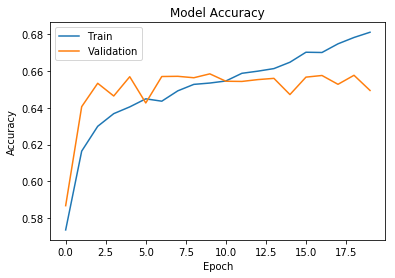

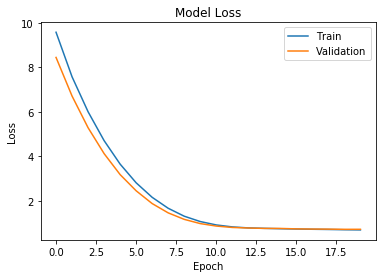

In [172]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# AUC score

In [173]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print(score)

0.706783012177


# Remove unsure predictions

In [184]:
y_pred = model.predict_proba(x_test, verbose=0)
ind1 = y_pred[:,0] > 0.6
ind2 = y_pred[:,1] > 0.6
ind = ind1 + ind2
y_pred2 = y_pred[ind]
y_test2 = y_test[ind]
x_test2 = x_test[ind]
print(ind)
print(y_pred2.shape)
print(y_pred.shape)
score = roc_auc_score(y_test2, y_pred2)
print(score)

loss_and_metrics = model.evaluate(x_test2, y_test2, verbose=2)
print(loss_and_metrics)

[ True  True False ..., False False  True]
(3244, 2)
(5000, 2)
0.746202304295
[0.70565459562141708, 0.40411786137908956, 0.69143033299581336]
